In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
import onnx
import onnxruntime

In [2]:
tfms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224, 224),antialias=False),
   torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std = [0.229, 0.224, 0.225])
])

In [3]:

#######define neural networks 
def conv(in_channels , out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels ,kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [4]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2 , stride=2),
        nn.ReLU(inplace=True)
    )

In [5]:
from torchvision.models import vgg16_bn

In [6]:
class UNet(nn.Module):
    def __init__(self, out_channels =12):#out_channels ==> number of segmented classes
        super().__init__()
        self.encoder = vgg16_bn(weights=torchvision.models.VGG16_BN_Weights.DEFAULT).features
        self.blocks = [0, 6, 13, 20, 27, 34]
        self.num_blocks = 5
        for block in range(self.num_blocks):
            setattr(self, f"block{block+1}", nn.Sequential(*self.encoder[self.blocks[block]:self.blocks[block+1]]))
        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottlenk = conv(512, 1024)
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512 , 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128+ 256 , 128)
        self.up_conv9 = up_conv(128 , 64)
        self.conv9 = conv(64+128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32+ 64 , 32)
        self.conv11 = nn.Conv2d(32, out_channels , kernel_size= 1 )
    
    def forward(self, x):
        block1 = self.block1(x)
        block2 =self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        bottleneck = nn.Dropout(0.2)(bottleneck)
        x = self.conv_bottlenk(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5],dim = 1)
        x = self.conv6(x)
        x = nn.Dropout(0.2)(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)
        x = nn.Dropout(0.2)(x)
        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim = 1)
        x = self.conv8(x)
        x = nn.Dropout(0.2)(x)
        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim = 1)
        x = self.conv9(x)
        x = nn.Dropout(0.2)(x)
        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim = 1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x




In [7]:
model = torch.load("unetmodel.pt")

In [8]:
model.eval()

UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [9]:
#export to onnx 
dummy_inputs = torch.randn(1 ,3 , 224, 224)
input_name = ['image']
output_name = ['mask']

In [10]:
torch.onnx.export(
    model ,
    dummy_inputs ,
    "onnxUNet.onnx",
    export_params=True ,
    verbose=True ,
    input_names= input_name ,
    output_names= output_name
)

c:\Users\Administrator\anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:1466: UserWarning: ONNX export mode is set to TrainingMode.EVAL, but operator 'dropout' is set to train=True. Exporting with train=True.
  warnings.warn(


================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [11]:
#create inference 
onnx_session = onnxruntime.InferenceSession("onnxUNet.onnx")
input_name = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name
print(input_name)
print(output_name)

image
mask


In [12]:
img  = cv2.imread("semantic_segmentation_dataset/dataset1/images_prepped_train/0016E5_08580.png", cv2.COLOR_BGR2RGB)
input_tensor = tfms(img/255.0)
input_tensor = np.expand_dims(input_tensor, axis=0).astype(np.float32)  # Add batch dimension


In [13]:
ort_outs = onnx_session.run([output_name], {input_name :input_tensor })

In [14]:
ort_outs[0].shape

(1, 12, 224, 224)

In [15]:
mask = ort_outs[0].argmax(axis = 1).squeeze(0)

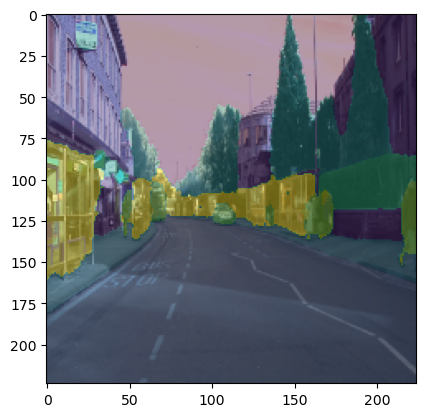

In [17]:
plt.imshow(cv2.resize(img, (224, 224)))
plt.imshow(mask, alpha = 0.4)

In [ ]:
def get_mask()